In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath,header=0, index_col=0)
    df.index = pd.to_datetime(df.index, format='%m-%d', yearfirst=False)
    #Remove the outlier
    df = df[df["Sales"] < 600]
    #Convert to series
    df = df.squeeze()
    #Resample the data to daily sales
    df = df.resample("D").mean().fillna(method="ffill")
    return df

In [3]:
shampo_sales = wrangle("shampoo.csv")
shampo_sales.shape
print(shampo_sales.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 70 entries, 1900-01-01 to 1900-03-11
Freq: D
Series name: Sales
Non-Null Count  Dtype  
--------------  -----  
70 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB
None


/var/folders/xk/dqpblzss3wdd3mcn7lz9ldw00000gn/T/ipykernel_7543/435739095.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample("D").mean().fillna(method="ffill")


In [4]:
shampo_sales.head()

Month
1900-01-01    266.0
1900-01-02    145.9
1900-01-03    183.1
1900-01-04    119.3
1900-01-05    180.3
Freq: D, Name: Sales, dtype: float64

In [5]:
shampo_sales.describe()

count     70.000000
mean     276.302857
std      105.231730
min      119.300000
25%      185.900000
50%      265.250000
75%      342.300000
max      581.300000
Name: Sales, dtype: float64

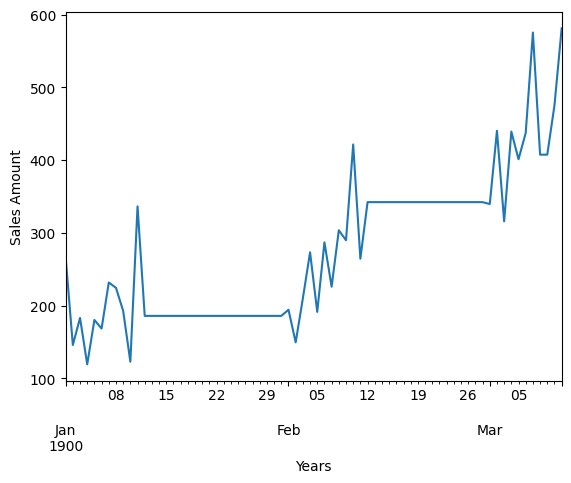

In [6]:
shampo_sales.plot()
plt.xlabel("Years")
plt.ylabel("Sales Amount");

<Axes: ylabel='Frequency'>

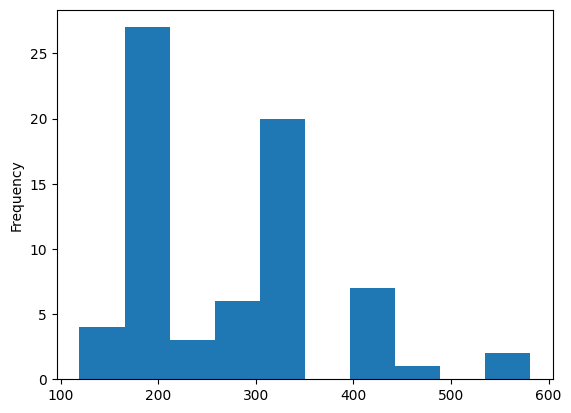

In [7]:
shampo_sales.plot(kind="hist")

<Axes: title={'center': 'Sales of shampe distribution'}>

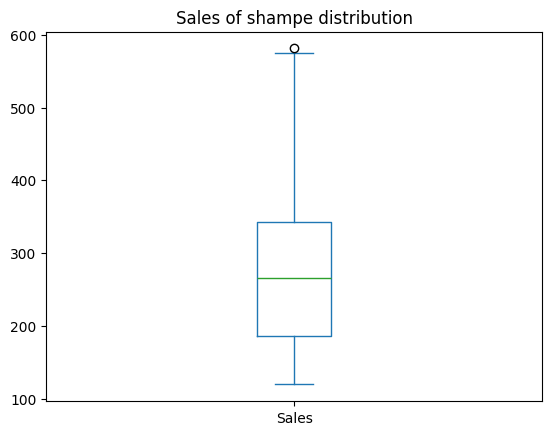

In [8]:
shampo_sales.plot(kind="box", title="Sales of shampe distribution")

In [9]:
shampo_sales.resample("D").mean().isnull().sum()


np.int64(0)

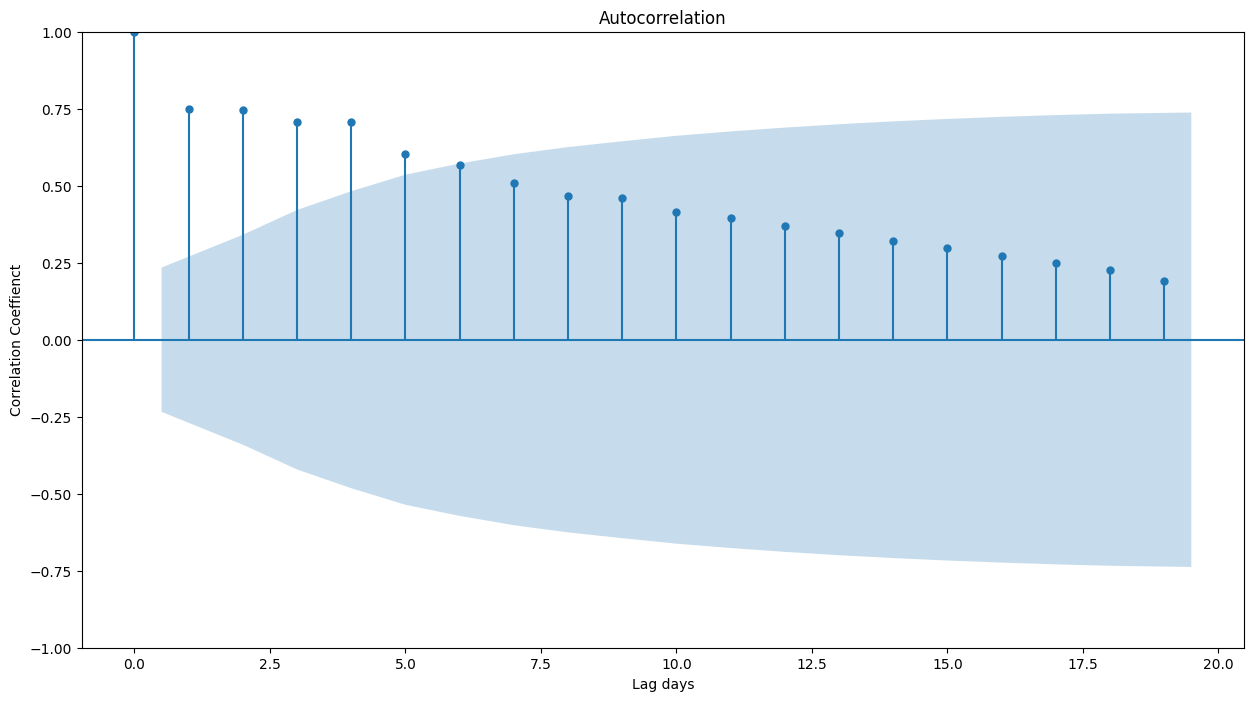

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(shampo_sales, ax=ax)
plt.xlabel("Lag days")
plt.ylabel("Correlation Coeffienct");

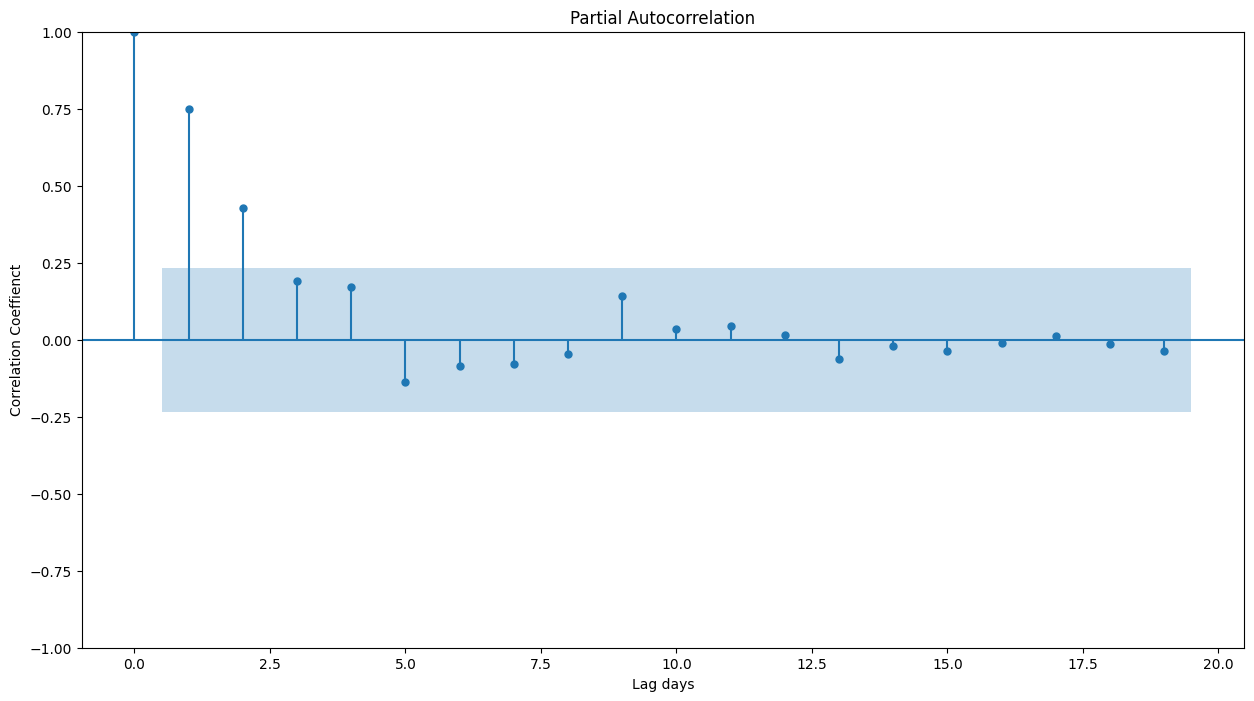

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(shampo_sales, ax=ax)
plt.xlabel("Lag days")
plt.ylabel("Correlation Coeffienct");

## Split Dataset

In [12]:
cutoff = int(len(shampo_sales) * 0.8)
y_train = shampo_sales.iloc[:cutoff]
y_test = shampo_sales[cutoff:]

print(len(shampo_sales))
print(len(y_train))
print(len(y_test))

70
56
14


## Build Model

### Baseline

In [13]:
y_train_mean = y_train.mean()
y_pred_baselin = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baselin)
print("Mean Sales:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Sales: 240.95
Baseline MAE: 69.06


### Model

In [14]:
model = AutoReg(y_train, lags=26).fit()

In [15]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26: ], y_pred)
print("Training MAE:", training_mae)

Training MAE: 11.695016349342199


In [16]:
y_train_resid = model.resid
y_train_resid.head()

Month
1900-01-27   -0.520691
1900-01-28   -7.898204
1900-01-29    6.324183
1900-01-30   -2.866556
1900-01-31    8.802689
Freq: D, dtype: float64

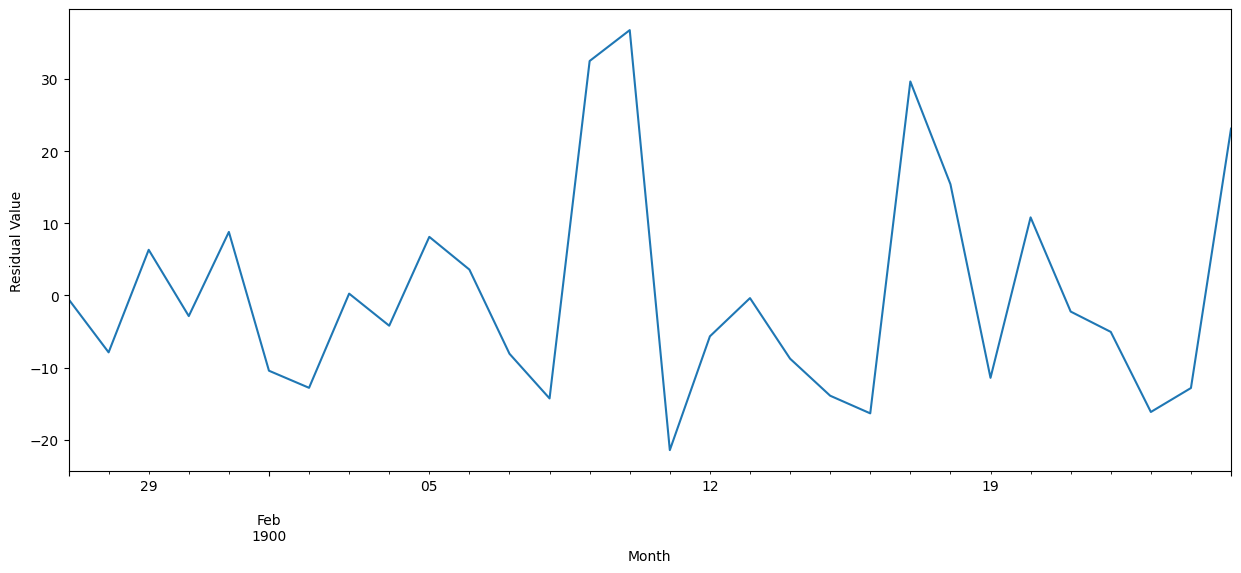

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax);

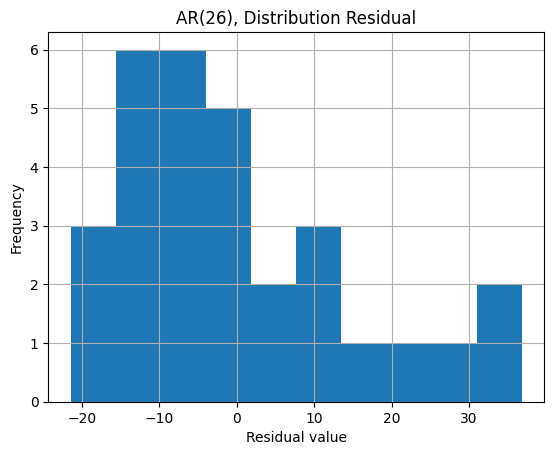

In [18]:
y_train_resid.hist()
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution Residual");

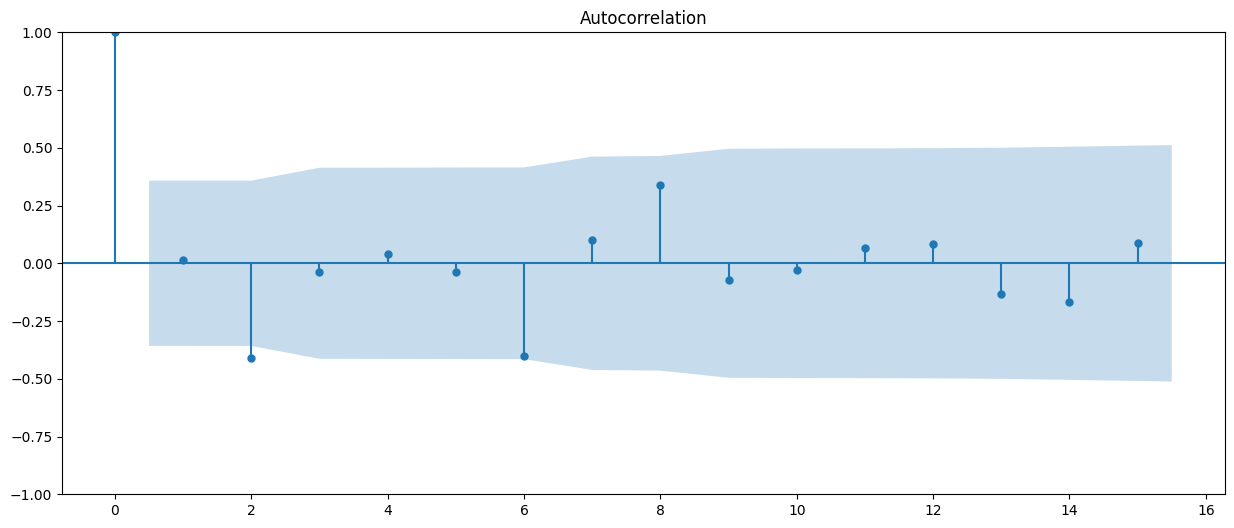

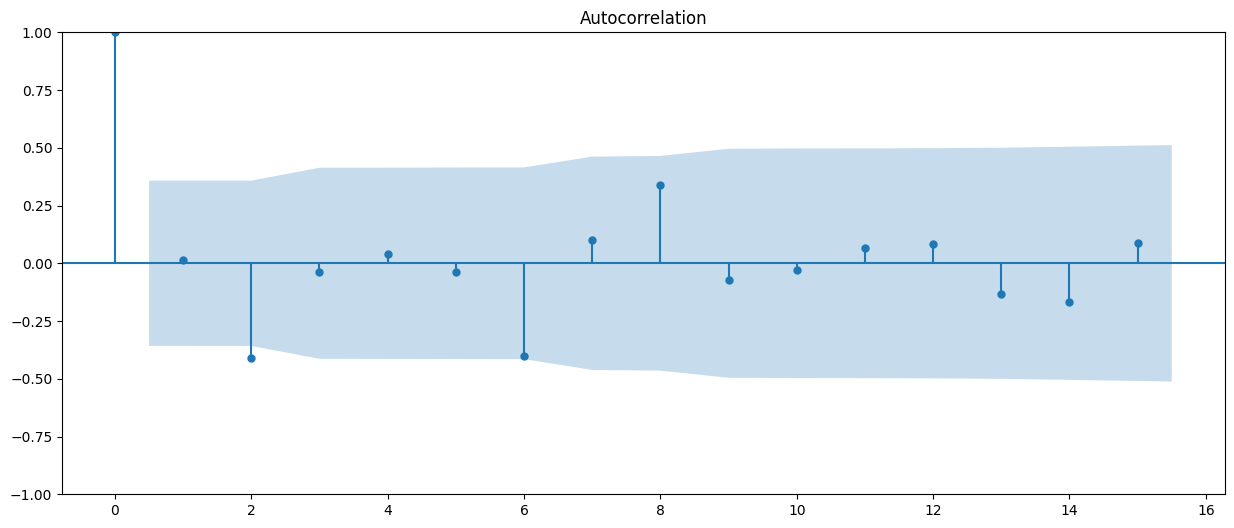

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)

## Evaluate

In [20]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
y_pred_test
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 690.1202140457236


In [21]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

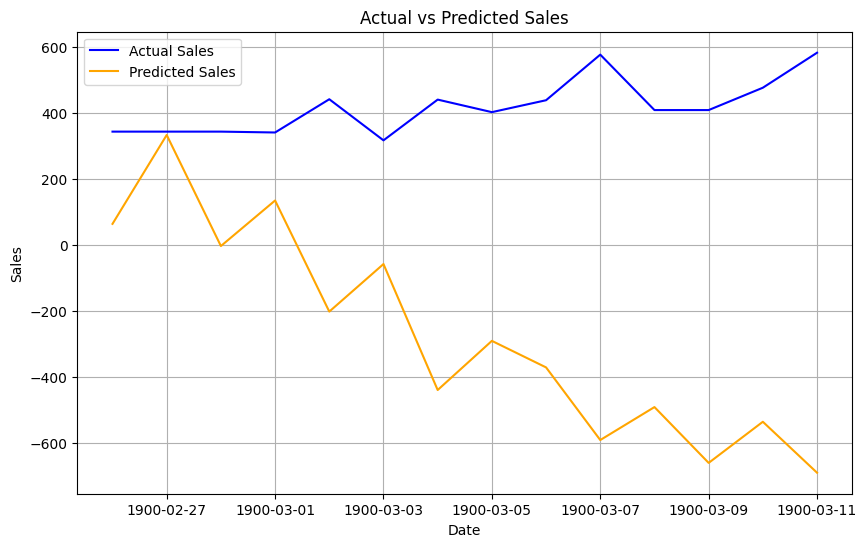

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_pred_test.index, df_pred_test["y_test"], label="Actual Sales", color="blue")
plt.plot(df_pred_test.index, df_pred_test["y_pred"], label="Predicted Sales", color="orange")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()